# Imports

In [1]:
from PIL import Image
from skimage.draw import line
import numpy as np
import matplotlib.pyplot as plt
import sys
import cv2
import os
import pickle
from rembg.bg import remove as remove_background

# Parameters

In [2]:
# Parameters 
INPUT_IMAGE_PATH = "img/taco.png"
OUTPUT_IMAGE_PATH = "out/" + INPUT_IMAGE_PATH[4:]

In [3]:
#
# Display 
#
def display_image(image):
    display(Image.fromarray(image))

def display_nails(nails, image):
    canvas = np.ones(image.shape, np.uint8) * 255
    for nail in nails:
        canvas[nail[0], nail[1]] = 0
    display_image(canvas)
    return canvas

def display_threads(lines, image):
    canvas = np.ones(image.shape, np.uint8) * 255
    for line in lines:
        canvas = cv2.line(canvas, (line[0][1], line[0][0]), (line[1][1], line[1][0]), 0, 1)
    display_image(canvas)
    return canvas

#
# Image
#

def decide_aspect_ratio(image):
    width, height = image.shape[1], image.shape[0]
    img_ar = width / height
    arr = np.asarray([1/1 , 3/4, 4/3, 4/5, 5/4])
    return arr[(np.abs(arr - img_ar)).argmin()]
    
def center_crop_to_aspect_ratio(image, aspect_ratio):
    width, height = image.shape[1], image.shape[0]
    img_ar = width / height
    if img_ar > aspect_ratio:
        return image[:, int((width - height * aspect_ratio) / 2):int((width + height * aspect_ratio) / 2)]
    else:
        return image[int((height - width / aspect_ratio) / 2):int((height + width / aspect_ratio) / 2), :]

def resize_to_aspect_ratio(image, aspect_ratio):
    if aspect_ratio == 1/1:
        return cv2.resize(image, (1561, 1561))
    elif aspect_ratio == 3/4:
        return cv2.resize(image, (1321, 1761))
    elif aspect_ratio == 4/3:
        return cv2.resize(image, (1761, 1321))
    elif aspect_ratio == 4/5:
        return cv2.resize(image, (1441, 1801))
    elif aspect_ratio == 5/4:
        return cv2.resize(image, (1801, 1441))

def get_input_image(): 
    image = cv2.imread(INPUT_IMAGE_PATH, 0)
    aspect_ratio = decide_aspect_ratio(image)

    image = center_crop_to_aspect_ratio(image, aspect_ratio)
    image = resize_to_aspect_ratio(image, aspect_ratio)

    return image, aspect_ratio

def get_new_image(dimensions):
    return np.ones(dimensions, np.uint8) * 255

def get_image_mask(image):
    is_success, im_buf_arr = cv2.imencode(".png", image)
    byte_im = im_buf_arr.tobytes()
    input = byte_im
    output = remove_background(input)
    image_np = np.frombuffer(output, np.uint8)
    img_np = cv2.imdecode(image_np, cv2.IMREAD_GRAYSCALE)
    for i in range(img_np.shape[0]):
        for j in range(img_np.shape[1]):
            if img_np[i, j] != 0:
                img_np[i, j] = 255
    kernel = np.ones((16, 16), np.uint8)
    image = cv2.erode(img_np, kernel, cv2.BORDER_REFLECT) 
    return image
    return cv2.Canny(image.copy(), 100, 200, apertureSize=3).astype(np.uint8)


def draw_line(image, line, color):
    return cv2.line(image, (line[0][1], line[0][0]), (line[1][1], line[1][0]), color, 1)

def draw_point(image, point, color):
    image[point[1], point[0]] = color
    return image

#
# Points
#
def get_data_from_dictionaries(aspect_ratio):
    ar = ""
    if aspect_ratio == 1/1:
        ar = "1x1"
    elif aspect_ratio == 3/4: # further x/y are swapped because the image is refered as a matrix
        ar = "4x3"
    elif aspect_ratio == 4/3:
        ar = "3x4"
    elif aspect_ratio == 4/5:
        ar = "5x4"
    elif aspect_ratio == 5/4:
        ar = "4x5"

    with open("dictionaries/" + ar + "_n.dat", "rb") as n, \
            open("dictionaries/" + ar + "_t.dat", "rb") as t, \
            open("dictionaries/" + ar + "_ntt.dat", "rb") as ntt, \
            open("dictionaries/" + ar + "_ttp.dat", "rb") as ttp:
        nails = pickle.load(n)
        threads = pickle.load(t)
        nail_to_threads = pickle.load(ntt)
        thread_to_points = pickle.load(ttp)

    return nails, threads, nail_to_threads, thread_to_points
    
def is_on_same_edge(point1, point2, dimensions):
    if point1[0] == 0 and point2[0] == 0:
        return True
    if point1[0] == dimensions[0] - 1 and point2[0] == dimensions[0] - 1:
        return True
    if point1[1] == 0 and point2[1] == 0:
        return True
    if point1[1] == dimensions[1] - 1 and point2[1] == dimensions[1] - 1:
        return True
    return False



def get_other_end_of_thread(thread, nail):
    if np.array_equal(thread[0], nail):
        return thread[1]
    return thread[0]





#
# Test 
#
# input_image = get_input_image()

# input_image_edges = get_input_image_edges()
# output_image = get_new_image(input_image.shape)



# print("Input image")
# display_image(input_image)

# print("Input image edges")
# display_image(input_image_edges)

# print("Output image")
# display_image(output_image)






  

# print("TEST FOR 1x1: ")
# INPUT_IMAGE_PATH = "img/cuts/almost1x1.png"
# display_image(cv2.imread(INPUT_IMAGE_PATH, 0))
# print("Current size: " + str(cv2.imread(INPUT_IMAGE_PATH, 0).shape))
# img = get_input_image()
# print("Final size: " + str(img.shape))
# print("Final aspect ratio: " + str(img.shape[1] / img.shape[0]))
# print("Final look: ")
# display_image(img)
# print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\n\n\n\n\n")

# print("TEST FOR 2x3: ")
# INPUT_IMAGE_PATH = "img/cuts/almost2x3.png"
# display_image(cv2.imread(INPUT_IMAGE_PATH, 0))
# print("Current size: " + str(cv2.imread(INPUT_IMAGE_PATH, 0).shape))
# img = get_input_image()
# print("Final size: " + str(img.shape))
# print("Final aspect ratio: " + str(img.shape[1] / img.shape[0]))
# print("Final look: ")
# display_image(img)
# print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\n\n\n\n\n")

# print("TEST FOR 3x2: ")
# INPUT_IMAGE_PATH = "img/cuts/almost3x2.png"
# display_image(cv2.imread(INPUT_IMAGE_PATH, 0))
# print("Current size: " + str(cv2.imread(INPUT_IMAGE_PATH, 0).shape))
# img = get_input_image()
# print("Final size: " + str(img.shape))
# print("Final aspect ratio: " + str(img.shape[1] / img.shape[0]))
# print("Final look: ")
# display_image(img)
# print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\n\n\n\n\n")

# print("TEST FOR 4x3: ")
# INPUT_IMAGE_PATH = "img/cuts/almost4x3.png"
# display_image(cv2.imread(INPUT_IMAGE_PATH, 0))
# print("Current size: " + str(cv2.imread(INPUT_IMAGE_PATH, 0).shape))
# img = get_input_image()
# print("Final size: " + str(img.shape))
# print("Final aspect ratio: " + str(img.shape[1] / img.shape[0]))
# print("Final look: ")
# display_image(img)
# print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\n\n\n\n\n")

# print("TEST FOR 3x4: ")
# INPUT_IMAGE_PATH = "img/cuts/almost3x4.png"
# display_image(cv2.imread(INPUT_IMAGE_PATH, 0))
# print("Current size: " + str(cv2.imread(INPUT_IMAGE_PATH, 0).shape))
# img = get_input_image()
# print("Final size: " + str(img.shape))
# print("Final aspect ratio: " + str(img.shape[1] / img.shape[0]))
# print("Final look: ")
# display_image(img)
# print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\n\n\n\n\n")



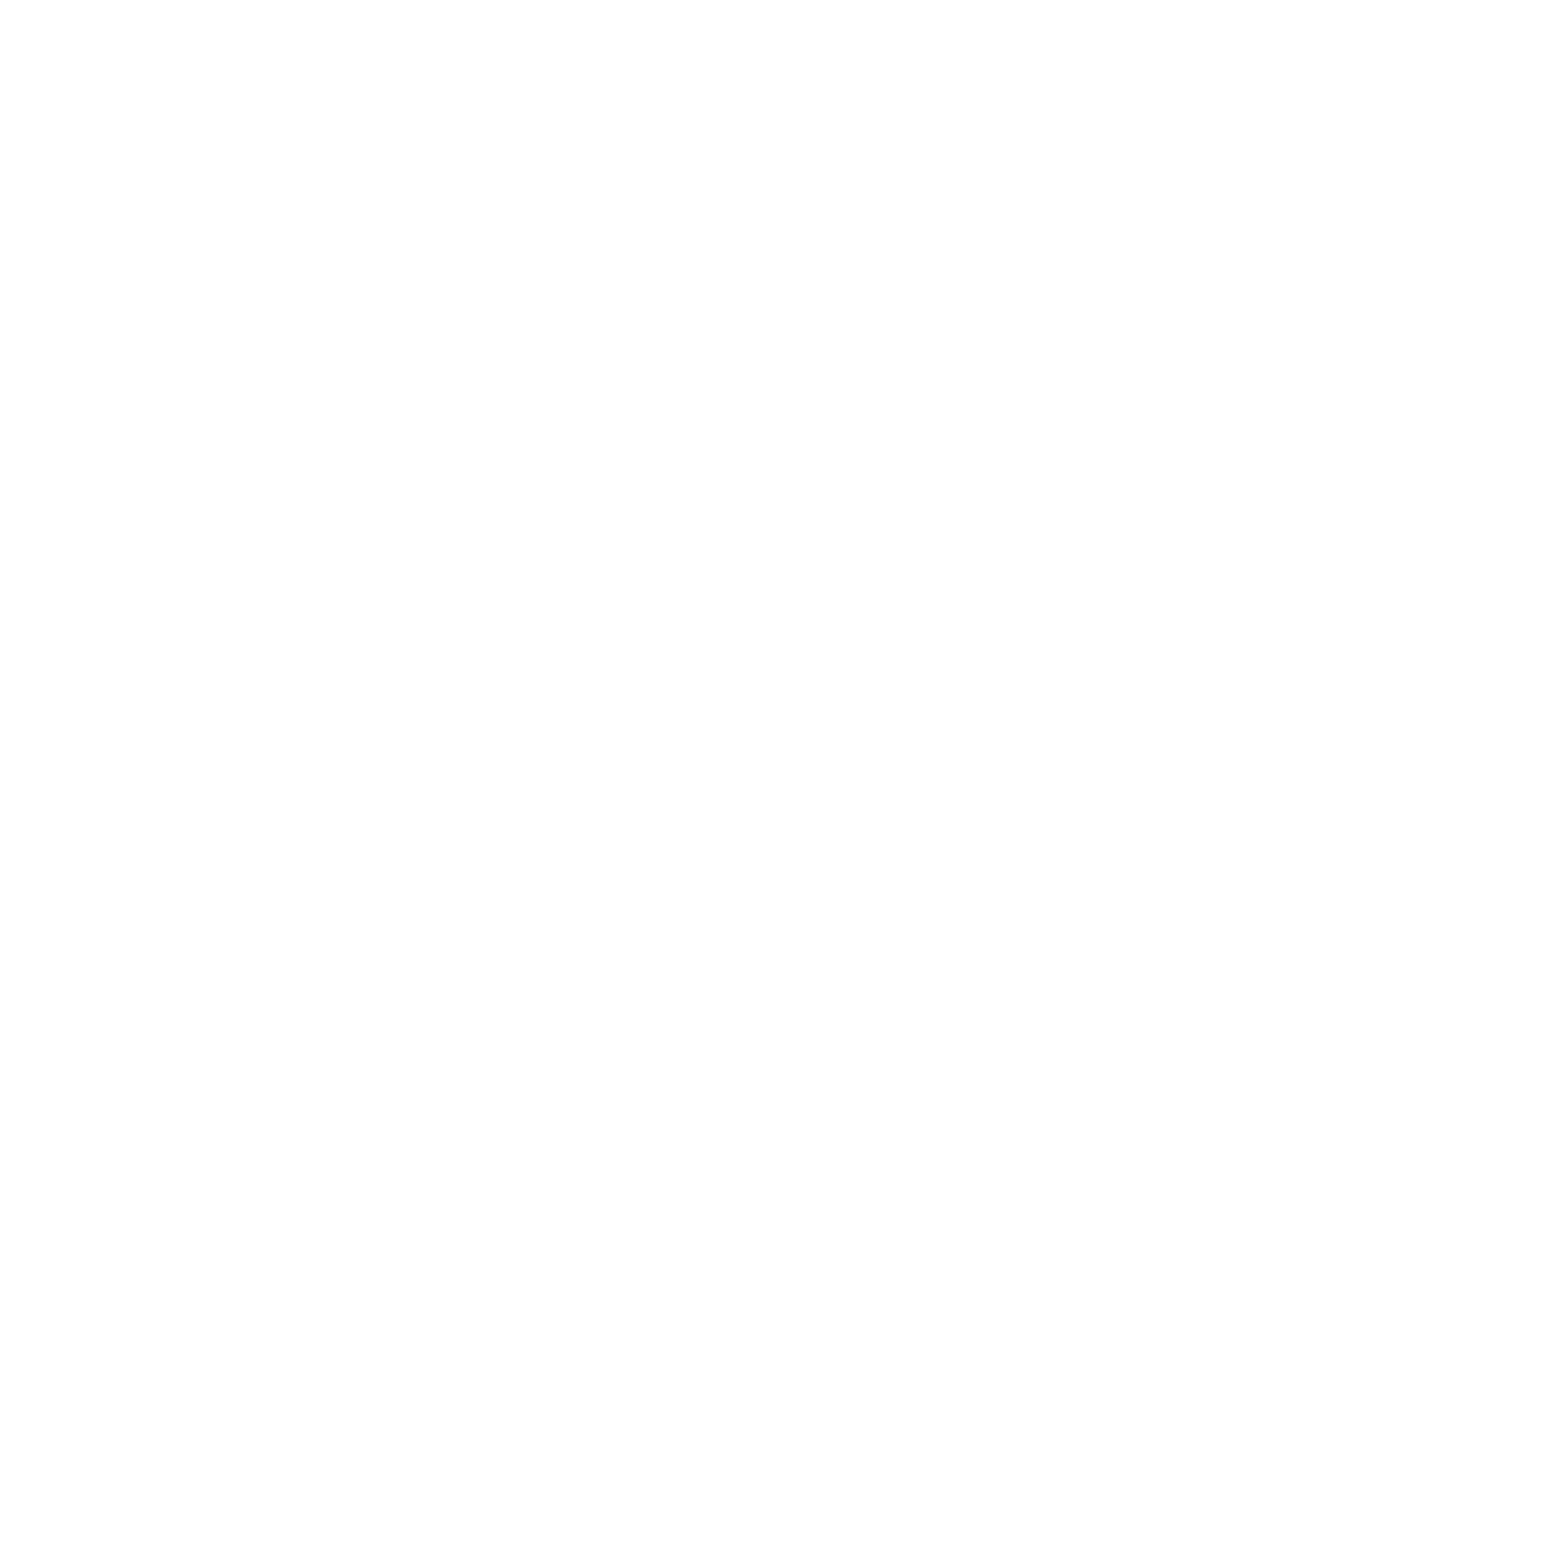

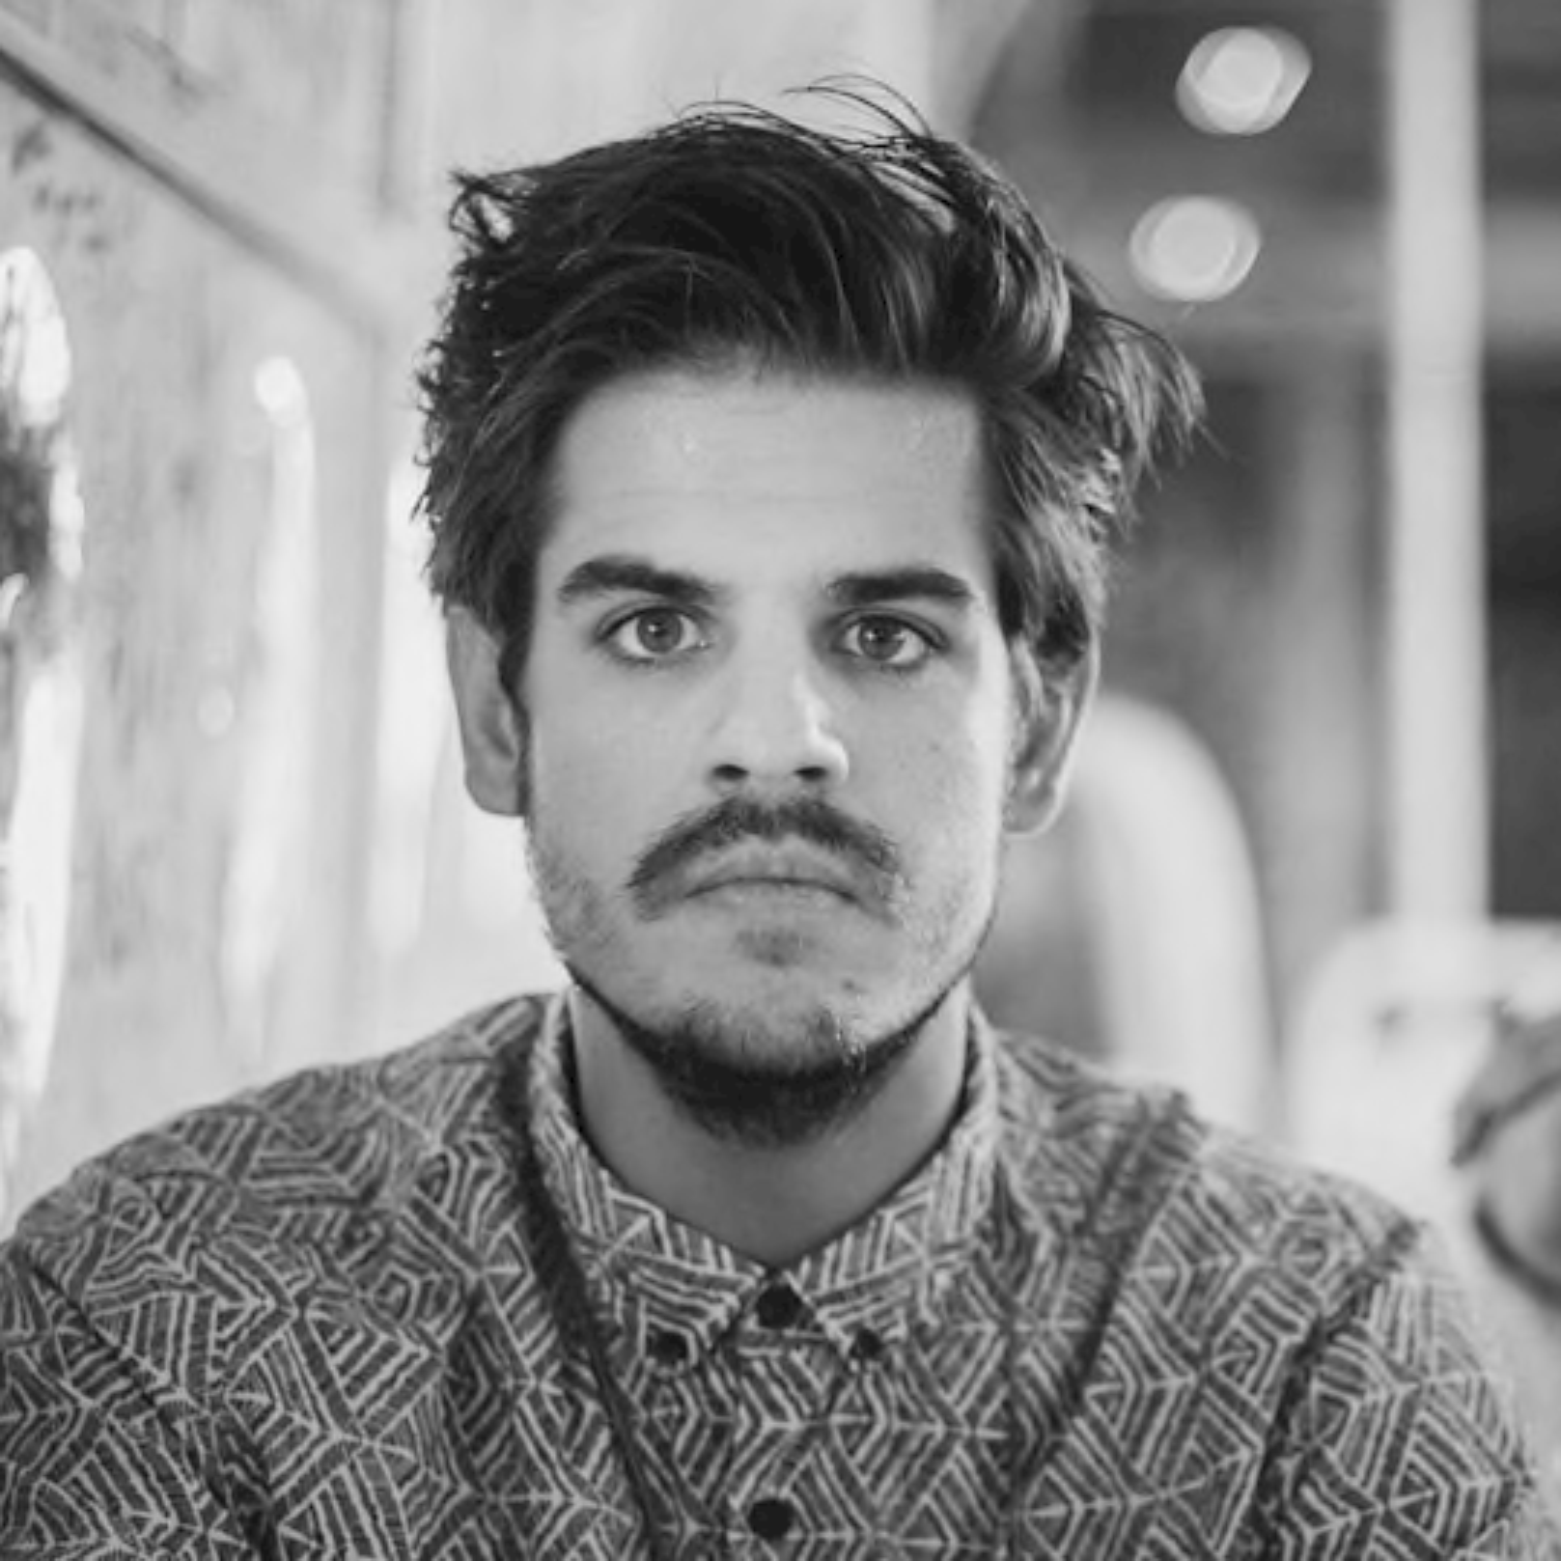

Current nail # 0 :  [0 0]


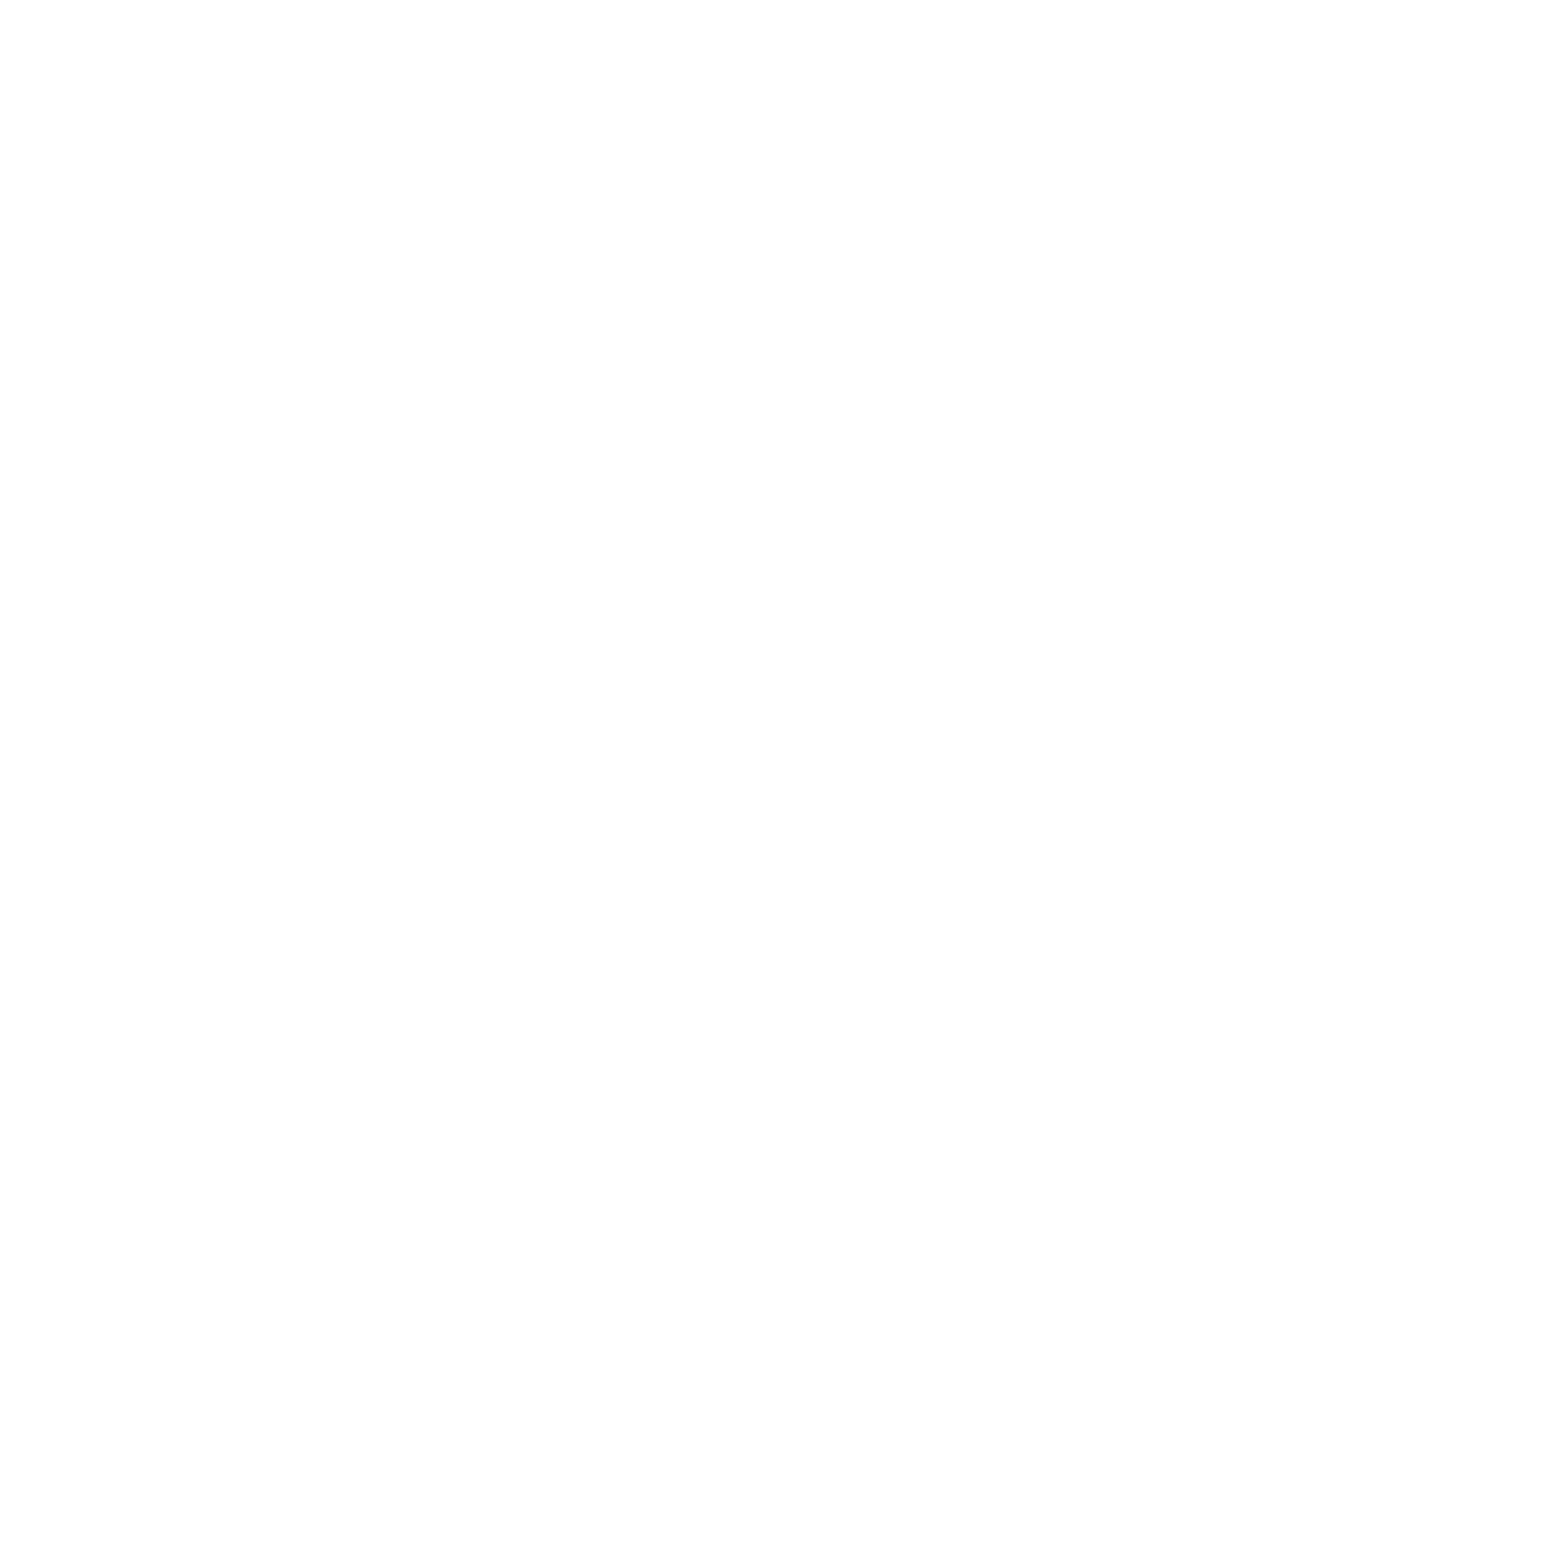

Current nail # 0 :  [0 0] , it's penalty:  97.69199231262013
Current nail # 100 :  [   0 1008] , it's penalty:  99.32210121716848
Current nail # 200 :  [1400 1560] , it's penalty:  111.86995515695067
Current nail # 300 :  [1544 1560] , it's penalty:  124.72056374119154
Current nail # 400 :  [1304 1560] , it's penalty:  138.20435618193466
Current nail # 500 :  [1560 1144]


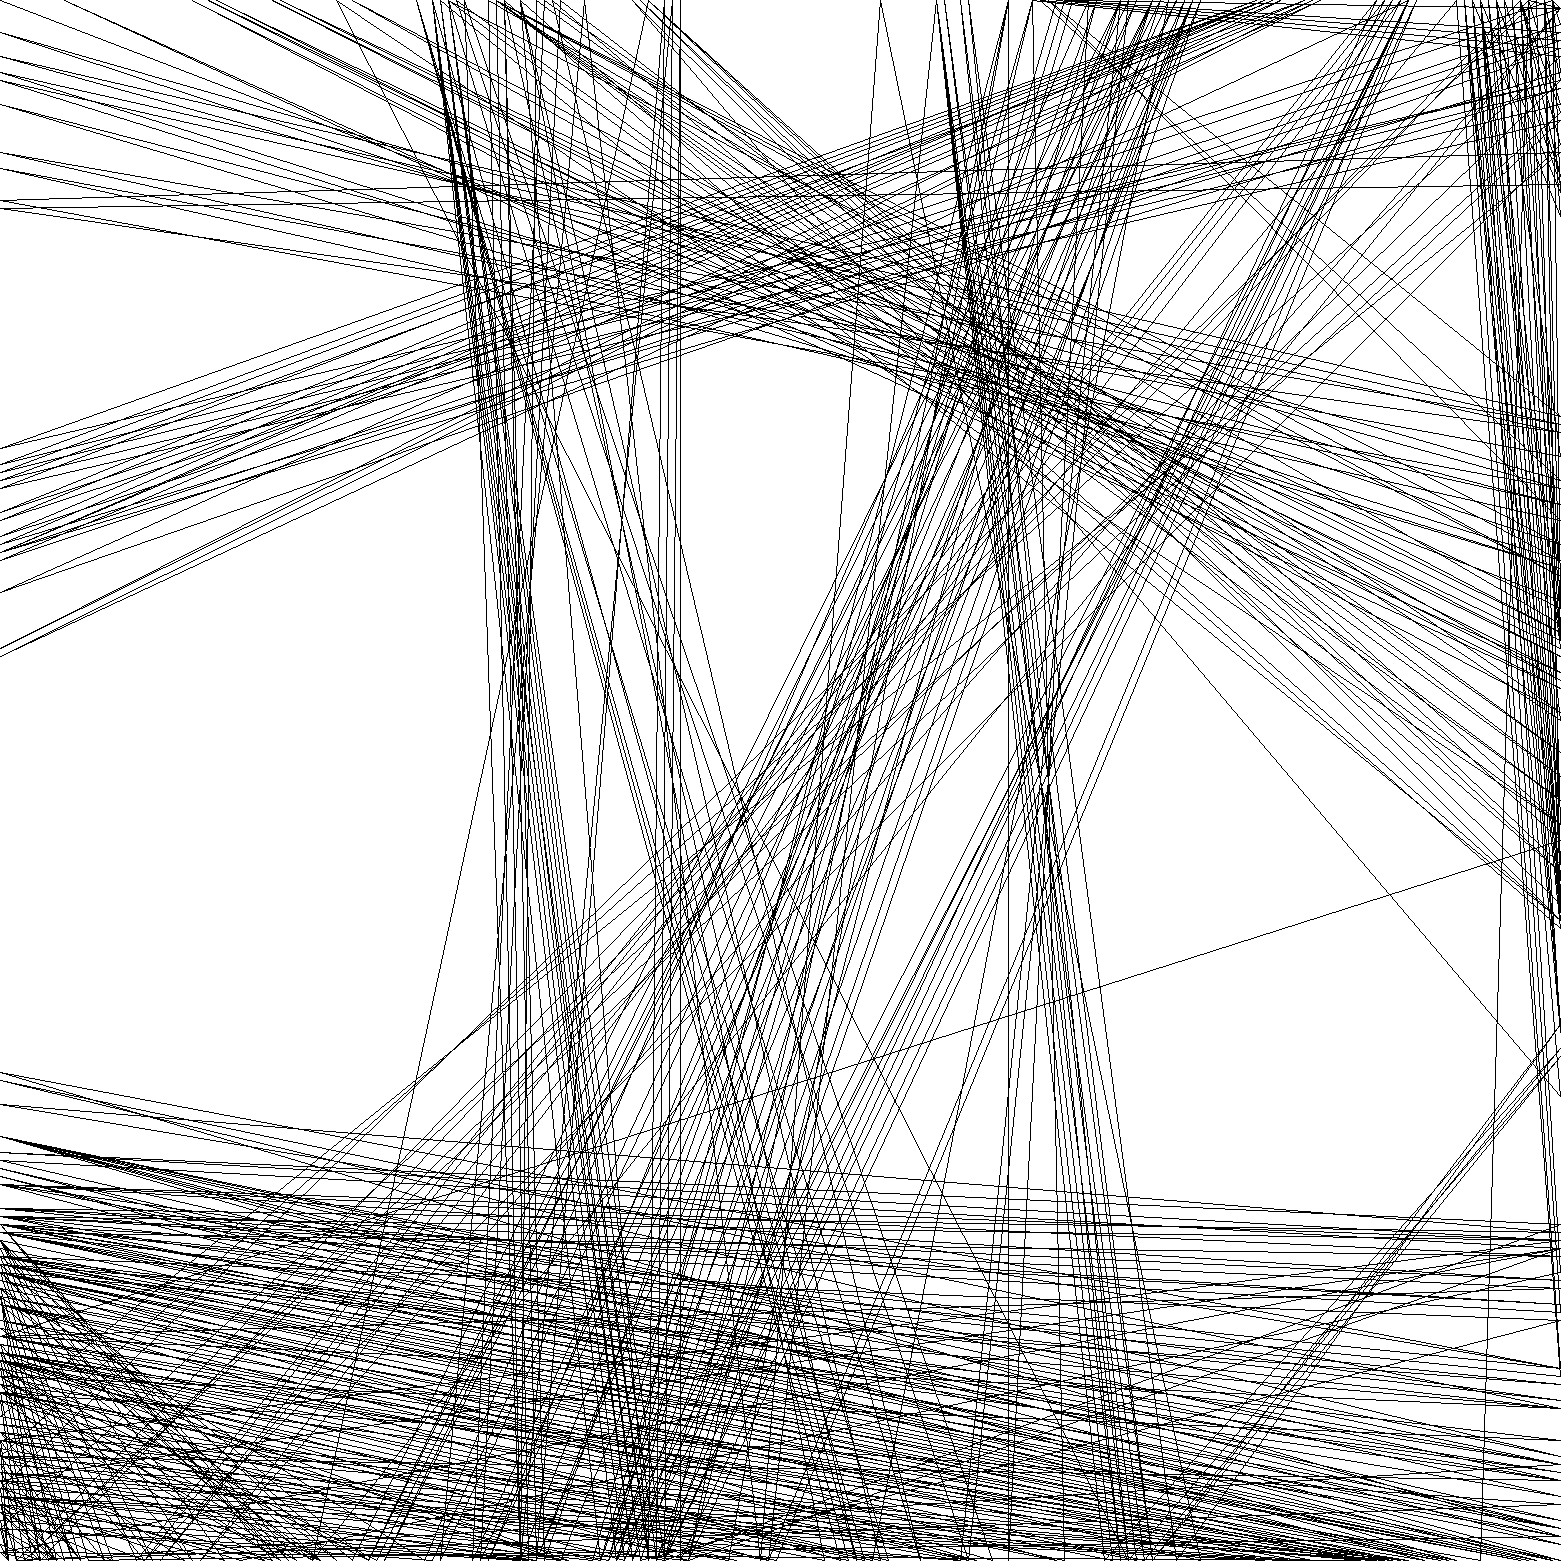

Current nail # 500 :  [1560 1144] , it's penalty:  142.46470211402948
Current nail # 600 :  [  0 760] , it's penalty:  149.95031210986267
Current nail # 700 :  [  0 960] , it's penalty:  157.79500320307494
Current nail # 800 :  [1560 1152] , it's penalty:  162.55061124694376
Current nail # 900 :  [ 648 1560] , it's penalty:  167.31428571428572
Current nail # 1000 :  [  0 432]


Current nail # 1000 :  [  0 432] , it's penalty:  171.92171684817424
Current nail # 1100 :  [1536 1560] , it's penalty:  174.1809523809524
Current nail # 1200 :  [ 0 48] , it's penalty:  180.61422165278665
Current nail # 1300 :  [  0 560] , it's penalty:  185.67379884689302
Current nail # 1400 :  [1016 1560] , it's penalty:  187.7072389493914
Current nail # 1500 :  [1560 1000]


Current nail # 1500 :  [1560 1000] , it's penalty:  190.3701473414478
Current nail # 1600 :  [ 592 1560] , it's penalty:  193.94003843689944
Current nail # 1700 :  [1560  264] , it's penalty:  198.14680134680134
Current nail # 1800 :  [ 472 1560] , it's penalty:  198.938689217759
Current nail # 1900 :  [1560 1176] , it's penalty:  203.85201793721973
Current nail # 2000 :  [1288 1560]


Current nail # 2000 :  [1288 1560] , it's penalty:  205.74652406417113
Current nail # 2100 :  [  0 800] , it's penalty:  207.7353482260184
Current nail # 2200 :  [1560  536] , it's penalty:  210.6613406795225
Current nail # 2300 :  [  0 200] , it's penalty:  212.38270339525945
Current nail # 2400 :  [1560 1392] , it's penalty:  210.2497041420118
Current nail # 2500 :  [1560  776]


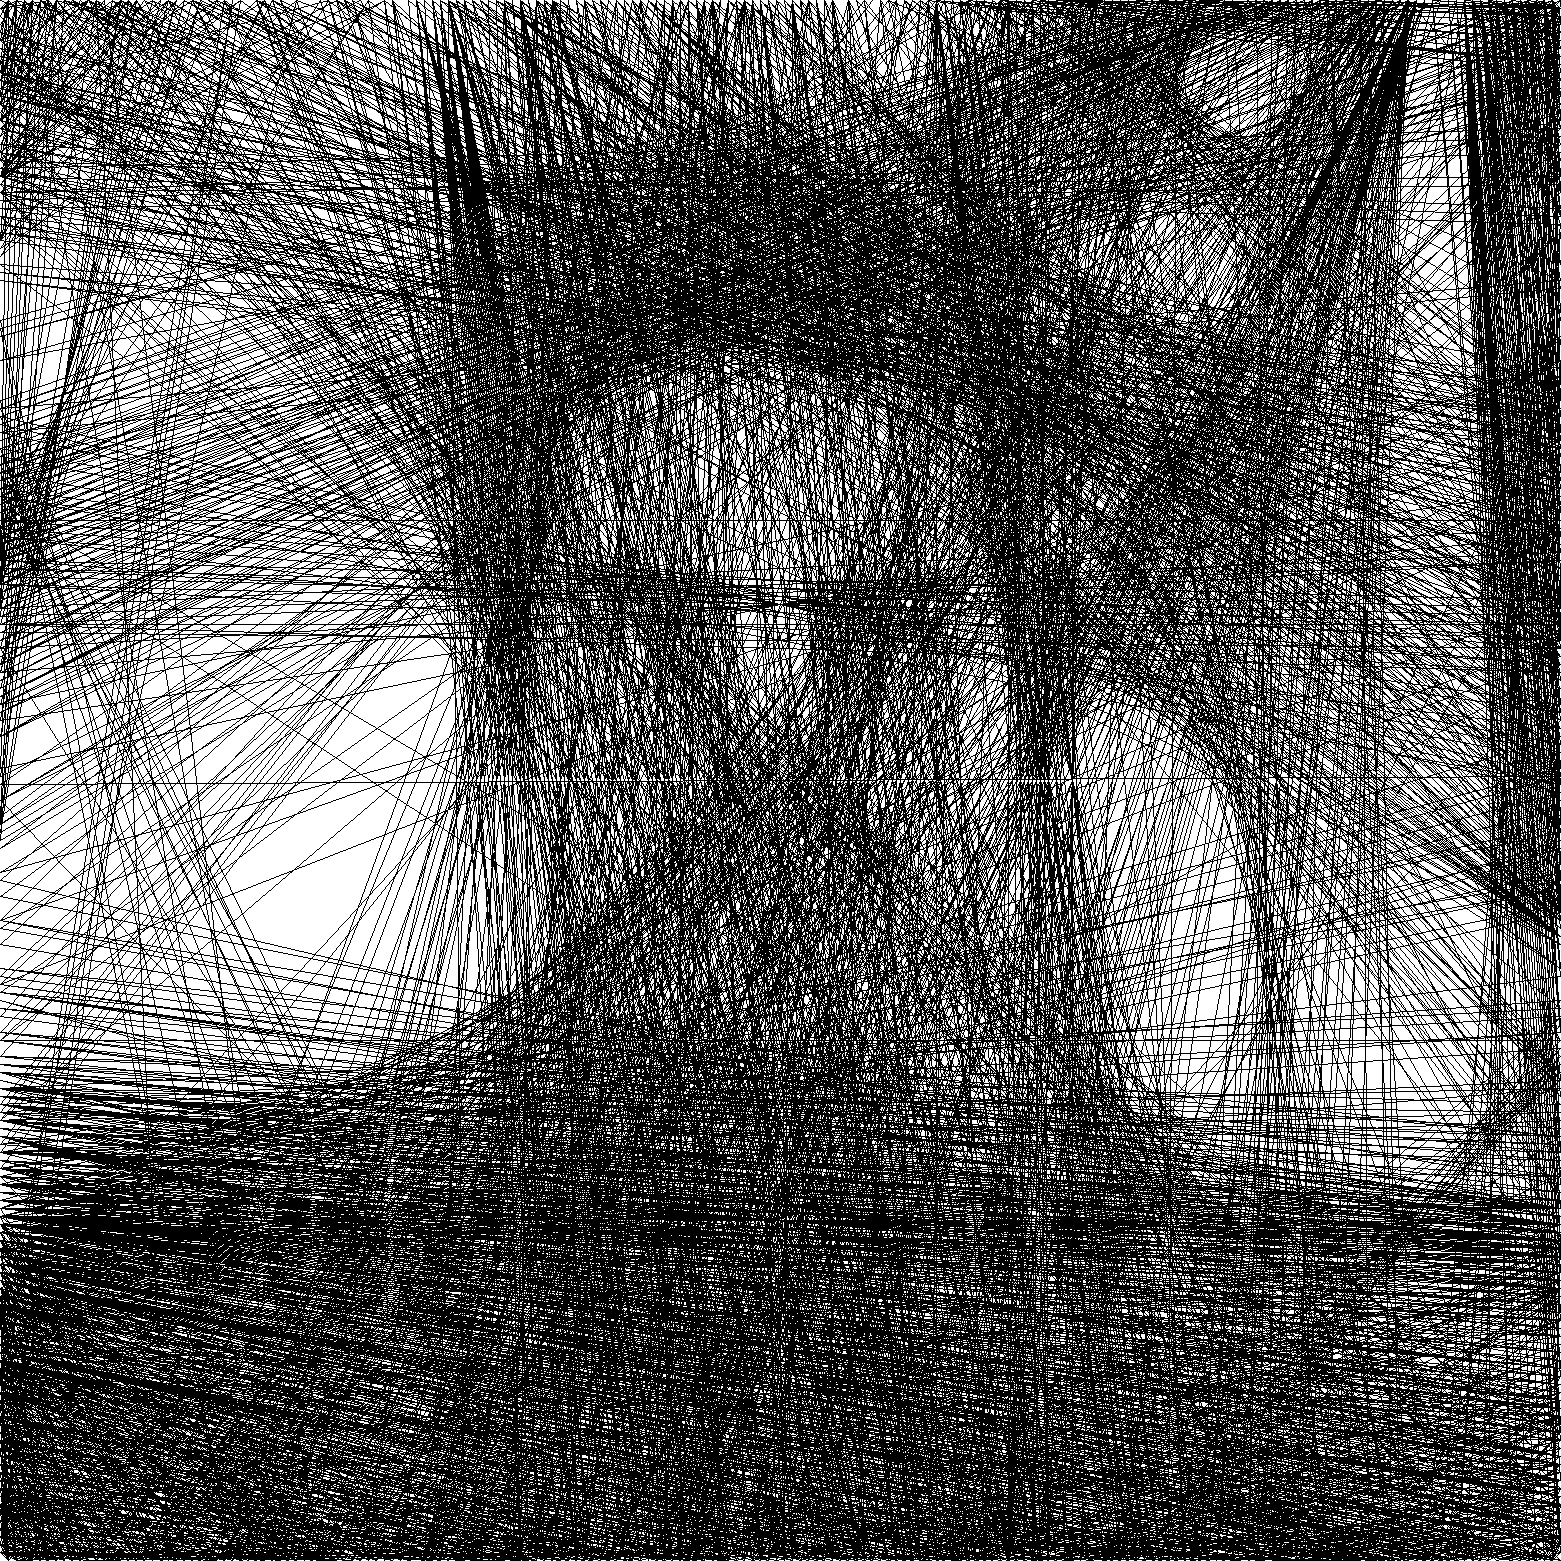

Current nail # 2500 :  [1560  776] , it's penalty:  214.94234465086484
Current nail # 2600 :  [1280    0] , it's penalty:  215.37470355731224
Current nail # 2700 :  [1056    0] , it's penalty:  218.60151371807
Current nail # 2800 :  [1560  616] , it's penalty:  220.71031390134527
Current nail # 2900 :  [1224 1560] , it's penalty:  221.47866752081998
Current nail # 3000 :  [1240 1560]


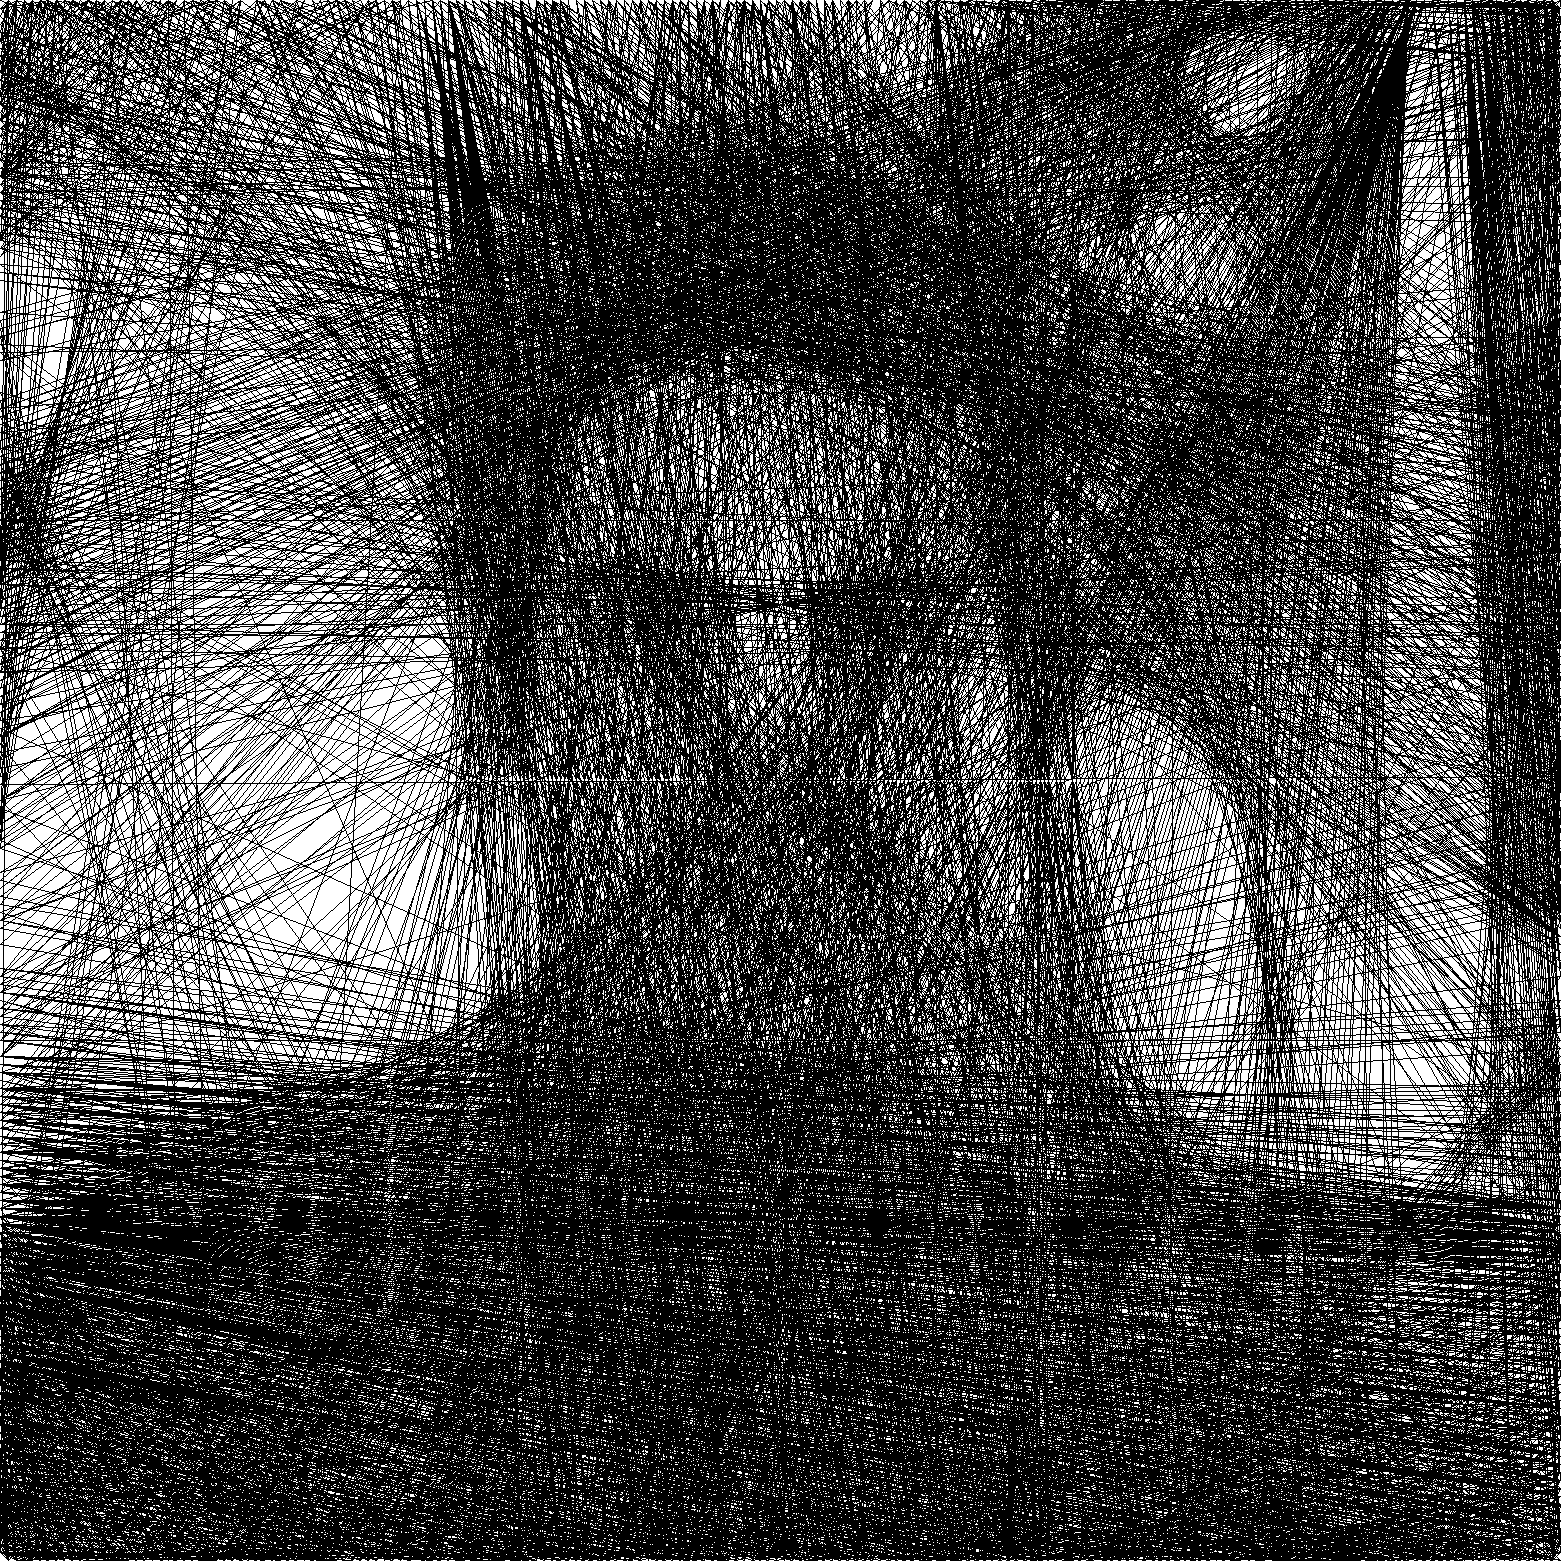

Current nail # 3000 :  [1240 1560] , it's penalty:  223.70072522159546
Current nail # 3100 :  [1560 1184] , it's penalty:  224.7655172413793
Current nail # 3200 :  [  0 952] , it's penalty:  225.70647021140294
Current nail # 3300 :  [1560 1464] , it's penalty:  223.91340206185566
Current nail # 3400 :  [   0 1000] , it's penalty:  227.11761691223572
Current nail # 3500 :  [1560  624]


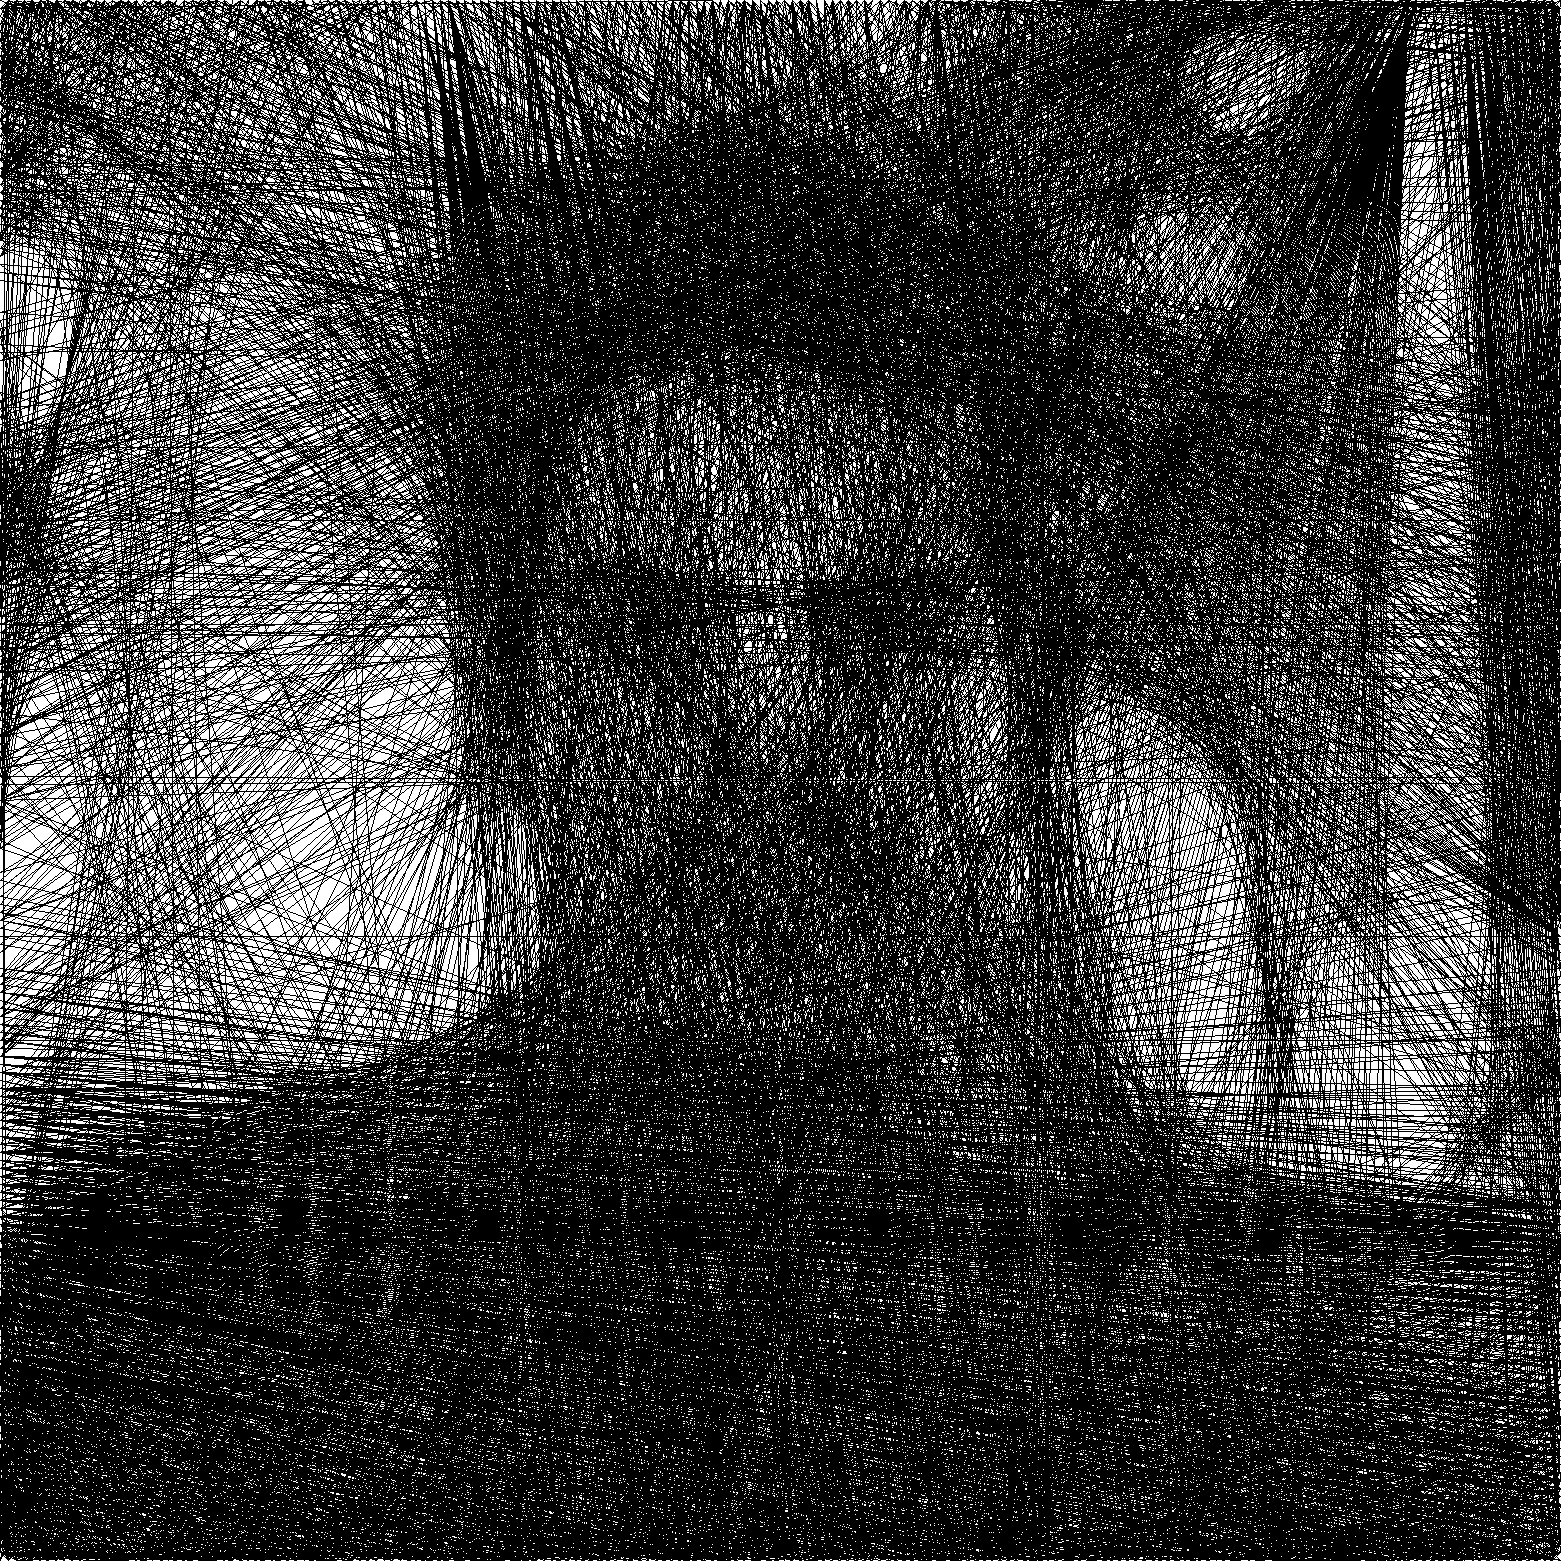

Current nail # 3500 :  [1560  624] , it's penalty:  229.00217809096733
Current nail # 3600 :  [ 496 1560] , it's penalty:  229.75855130784709
Current nail # 3700 :  [1560  232] , it's penalty:  231.1202846975089
Current nail # 3800 :  [1560  656] , it's penalty:  231.52298325722984
Current nail # 3900 :  [1560 1040] , it's penalty:  232.7096732863549
Current nail # 4000 :  [464   0]


Current nail # 4000 :  [464   0] , it's penalty:  233.16773017319963
Current nail # 4100 :  [952   0] , it's penalty:  234.41165919282508
Current nail # 4200 :  [  0 448] , it's penalty:  235.4732863549007


KeyboardInterrupt: 

In [4]:
# calculetes how much inputting this thread will decrease the quality of input image, hence improving the output image



def get_thread_panelty(thread, ttp, input_image, input_image_mask):
    a = input_image[tuple(ttp[thread.tobytes()].T)].sum()
    b = input_image_mask[tuple(ttp[thread.tobytes()].T)].sum()
    c = 0.04
    return (a - (c*b)) / len(ttp[thread.tobytes()])

# which thread cover the most black and the least white
def get_best_fitting_thread(ntt, current_nail, ttp, input_image, input_image_edges): 
    current_threads = ntt[current_nail.tobytes()]
    best_fitting_thread = current_threads[0]
    best_fitting_thread_penalty = 999999999
    for thread in current_threads:
        penalty = get_thread_panelty(thread, ttp, input_image, input_image_edges)
        if penalty < best_fitting_thread_penalty:
            best_fitting_thread = thread
            best_fitting_thread_penalty = penalty

    return best_fitting_thread, best_fitting_thread_penalty


input_image, ar = get_input_image()
input_image_mask = get_image_mask(input_image)
output_image = get_new_image(input_image.shape)



n, t, ntt, ttp = get_data_from_dictionaries(ar)

used_threads = []
current_nail = n[0] # might change to start from a different nail
current_input_image = input_image.copy()


display_threads(used_threads, output_image)
display_image(current_input_image)
display_image(input_image_mask)

for i in range(0, 5000):
    
    if i % 500 == 0: 
        print("Current nail #", i, ": ", str(current_nail))
        display_threads(used_threads, output_image)
        
    current_threads = ntt[current_nail.tobytes()]
    if len(current_threads) == 0:
        print("No threads for nail", current_nail)
        break
    selected_thread, selected_thread_penalty = get_best_fitting_thread(ntt, current_nail, ttp, current_input_image, input_image_mask)
    next_nail = get_other_end_of_thread(selected_thread, current_nail)

    used_threads.append(selected_thread)


    # Delete selected thread from ntt
    ntt[current_nail.tobytes()] = np.array([a for a, skip in zip(ntt[current_nail.tobytes()], 
                                    [np.allclose(a, selected_thread) for a in ntt[current_nail.tobytes()]]) if not skip])

    # Delete selected thread from next_nail
    ntt[next_nail.tobytes()] = np.array([a for a, skip in zip(ntt[next_nail.tobytes()], 
                                    [np.allclose(a, selected_thread) for a in ntt[next_nail.tobytes()]]) if not skip])
    
    # if len(ntt[current_nail.tobytes()]) == 1:
    #     for thread in ntt[current_nail.tobytes()]:
    #         print(thread)
    #         other_nail = get_other_end_of_thread(thread, current_nail)
    #         print(other_nail)
    #         ntt[current_nail.tobytes()] = np.array([a for a, skip in zip(ntt[current_nail.tobytes()], 
    #                                 [np.allclose(a, thread) for a in ntt[current_nail.tobytes()]]) if not skip])
    #         ntt[other_nail.tobytes()] = np.array([a for a, skip in zip(ntt[other_nail.tobytes()], 
    #                                 [np.allclose(a, thread) for a in ntt[other_nail.tobytes()]]) if not skip])


    if i % 100 == 0: 
        print("Current nail #", i, ": ", str(current_nail), ", it's penalty: ", selected_thread_penalty)

    draw_line(current_input_image, selected_thread, 255)

    THRESHOLD = 250
    if selected_thread_penalty > THRESHOLD:
        print("Current nail #", i, ": ", str(current_nail), ", it's penalty: ", selected_thread_penalty)
        print("Too much penalty, breaking")
        continue
    current_nail = next_nail

cv2.imwrite("output.png", display_threads(used_threads, output_image))

